In [ ]:
!pip install tensorflow transformers datatable keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import datatable as dt 
import pandas as pd

In [ ]:
# Load the dataset
data = dt.fread("drive/MyDrive/goodreads_train.csv",fill=True)

# Convert the datatable Frame to pandas DataFrame (for easier manipulation)
df = data.to_pandas()
df.columns = ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
print(df.dtypes)
print(len(df.index))
# Remove rows where rating is NAN
df = df.dropna(subset=['rating'])
df = df[pd.to_numeric(df['rating'], errors='coerce').notna()]
print(len(df.index))

# Extract the texts and labels
texts = df["review_text"].astype(str).tolist()
labels = df["rating"]
labels = pd.to_numeric(labels).tolist()

user_id         object
book_id          int32
review_id       object
rating           int32
review_text     object
date_added      object
date_updated    object
read_at         object
started_at      object
n_votes          int32
n_comments       int32
dtype: object
900000
900000


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
input_ids = tokenizer(texts, padding=True, truncation=True, return_tensors="tf").input_ids
attention_masks = tokenizer(texts, padding=True, truncation=True, return_tensors="tf").attention_mask
input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

In [ ]:

# Convert labels to a numpy array
labels = np.array(labels)

# Split data into train and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(((train_inputs, train_masks), train_labels))
train_data = train_data.shuffle(100).batch(6)

val_data = tf.data.Dataset.from_tensor_slices(((val_inputs, val_masks), val_labels))
#val_data = val_data.shuffle(100).batch(6)


In [ ]:
# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy()

# model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
# model.fit(train_data, epochs=1, validation_data=val_data)
# model.save_pretrained("models/bert_model")

In [ ]:
# from google.colab import files
# files.download("models/bert_model/tf_model.h5")
# files.download("models/bert_model/config.json")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
model = TFBertForSequenceClassification.from_pretrained("drive/MyDrive/BERT", num_labels=6)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=[metric,'accuracy', Precision(), Recall()])

# Flatten the true labels and store predictions
y_true_flat = []
y_pred_labels = []

# Prepare inputs for model prediction
def format_inputs(input_ids, attention_mask):
    return {"input_ids": tf.expand_dims(input_ids, axis=0), "attention_mask": tf.expand_dims(attention_mask, axis=0)}

formatted_inputs = []

# Evaluate the model on the test data
for (input_ids, attention_mask), y in val_data:
    y_true_flat.extend(y.numpy().flatten())
    formatted_input = format_inputs(input_ids, attention_mask)
    formatted_inputs.append(formatted_input)
    y_pred = model.predict(formatted_inputs)
    y_pred_labels.extend(np.argmax(y_pred.logits, axis=1))

# Calculate the evaluation metrics
test_accuracy = accuracy_score(y_true_flat, y_pred_labels)
test_precision = precision_score(y_true_flat, y_pred_labels, average='weighted')
test_recall = recall_score(y_true_flat, y_pred_labels, average='weighted')
test_f1_score = f1_score(y_true_flat, y_pred_labels, average='weighted')

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1_score:.4f}")

Some layers from the model checkpoint at drive/MyDrive/BERT were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at drive/MyDrive/BERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


ValueError: ignored

In [ ]:
# Print confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_flat, y_pred_labels))
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_labels))

In [ ]:
tokenized_test = tokenizer(list(df['review_text']), return_tensors="np", max_length=512, truncation=True, padding=True)
tokenized_test = dict(tokenized_test)

print(len(tokenized_test))

preds = model.predict(tokenized_test)

3
1086/1086 [==============================] - 1444s 1s/step


In [ ]:
#Create dataframe with 
print(preds)
argmax = np.argmax(preds.logits, axis=1)
print(argmax)
df['bert_pred'] = argmax
df.head()
df.to_csv('drive/MyDrive/bert_preds.csv')

TFSequenceClassifierOutput(loss=None, logits=array([[-1.9120698 , -2.1792557 , -0.90577155,  1.2513585 ,  1.852728  ,
         0.4839541 ],
       [-1.209774  ,  0.41081187,  1.7506548 ,  1.8200078 , -0.8101518 ,
        -2.767747  ],
       [-2.0216818 , -3.4187758 , -2.372704  ,  0.8854505 ,  3.0064838 ,
         2.171838  ],
       ...,
       [-1.7780755 ,  0.11009672,  2.3461308 ,  2.4712594 , -0.96132493,
        -3.1720989 ],
       [-1.7119534 , -3.4534829 , -1.328687  ,  2.755664  ,  3.0228465 ,
        -0.7313982 ],
       [ 1.3476145 , -1.2533708 , -0.83523196,  0.04617133,  0.4425587 ,
         0.23032694]], dtype=float32), hidden_states=None, attentions=None)
[4 3 4 ... 3 4 0]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#Load bert_preds from drive
df = pd.read_csv('drive/MyDrive/bert_preds_vector.csv')
# y_pred = df['bert_pred']
# y_true = df['rating']
# # Generate and print the classification report
# report = classification_report(y_true, y_pred)
# print(report)

In [ ]:
data = dt.fread("drive/MyDrive/out.csv",fill=True)#.head(300000)

# Convert the datatable Frame to pandas DataFrame (for easier manipulation)
out = data.to_pandas()
print(out.dtypes)
print(out.columns)

user_id                 object
review_id               object
rating                   int32
review_text             object
date_added              object
date_updated            object
read_at                 object
started_at              object
n_votes                  int32
n_comments               int32
isbn                    object
text_reviews_count     float64
series                  object
country_code            object
language_code           object
asin                    object
is_ebook                  bool
average_rating         float64
kindle_asin             object
description             object
format                  object
link                    object
authors                 object
publisher               object
num_pages              float64
publication_day        float64
isbn13                  object
publication_month      float64
edition_information     object
publication_year       float64
url                     object
image_url               object
ratings_

In [ ]:
#df = out

# Combine the three columns into a single date string column
out['publication_date'] = out['publication_year'].fillna(0).astype(int).astype(str) + '-' + out['publication_month'].fillna(0).astype(int).astype(str) + '-' + out['publication_day'].fillna(0).astype(int).astype(str)

# Convert the date string column to a datetime object
# df['publication_date'] = pd.to_datetime(df['date_string'], format='%Y-%m-%d', errors='coerce')

# Drop the original columns and the temporary date_string column
out = out.drop(columns=['publication_day', 'publication_month', 'publication_year'])

# Display the updated dataframe
print(out.head())

                            user_id                         review_id  rating  \
0  4672eb229c808b792b8ea95f01f19784  6b75b2116cd8145e0c18eb5387d726f0       5   
1  5f550cc8d90df1759eda1496621187d8  350aaf30c659d278a67d11f7f05cd9be       5   
2  d8c86e725d683042e9eec675f294d7d4  9b8c03b86291a778ff7cc89e1507f2b6       4   
3  90c53a2210f33ada709caa5aed0993c2  0d102a592005c63b295e06a7fe10232c       5   
4  c4f655f2ed79599a9259d7762313f3f3  e9afb986d674983999afb6d60f41a6aa       2   

                                         review_text  \
0       One of the best books in the series I think.   
1  It only gets better as the suspense builds in ...   
2  First of all, Im in love with these books sinc...   
3  This book didn't disappoint me at all. I absol...   
4                                              Urgh.   

                       date_added                    date_updated  \
0  Thu Jan 03 12:15:33 -0800 2013  Sun Oct 02 14:00:28 -0700 2016   
1  Mon Sep 19 21:01:23 -0700 2016  Sun

In [ ]:
print(df.iloc[100000]['url'])

https://www.goodreads.com/book/show/91475.White_Night


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dataframe called 'df'
df = pd.read_csv('drive/MyDrive/merged_df_vector.csv').fillna(0)
print(df.columns)
# df.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])
df.drop(df.columns[[0, 1, 2]], axis=1, inplace=True)
# 1. Convert string columns to numeric values using Label Encoding
label_encoder = LabelEncoder()
df = df.apply(lambda col: label_encoder.fit_transform(col.astype(str)), axis=0, result_type='expand')

for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column has string data type
        df[column] = label_encoder.fit_transform(df[column])

<ipython-input-29-abaafa2e23d9>:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/MyDrive/merged_df_vector.csv').fillna(0)


Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'user_id', 'book_id',
       'review_id', 'rating', 'review_text', 'date_added', 'date_updated',
       'read_at', 'started_at', 'n_votes', 'n_comments', '0', '1', '2', '3',
       '4', '5', 'authors', 'ratings_count', 'format', 'edition_information',
       'series', 'language_code', 'isbn', 'is_ebook', 'asin', 'publisher',
       'average_rating', 'work_id', 'num_pages', 'text_reviews_count',
       'description', 'isbn13', 'image_url', 'kindle_asin', 'url', 'link',
       'publication_date', 'country_code'],
      dtype='object')


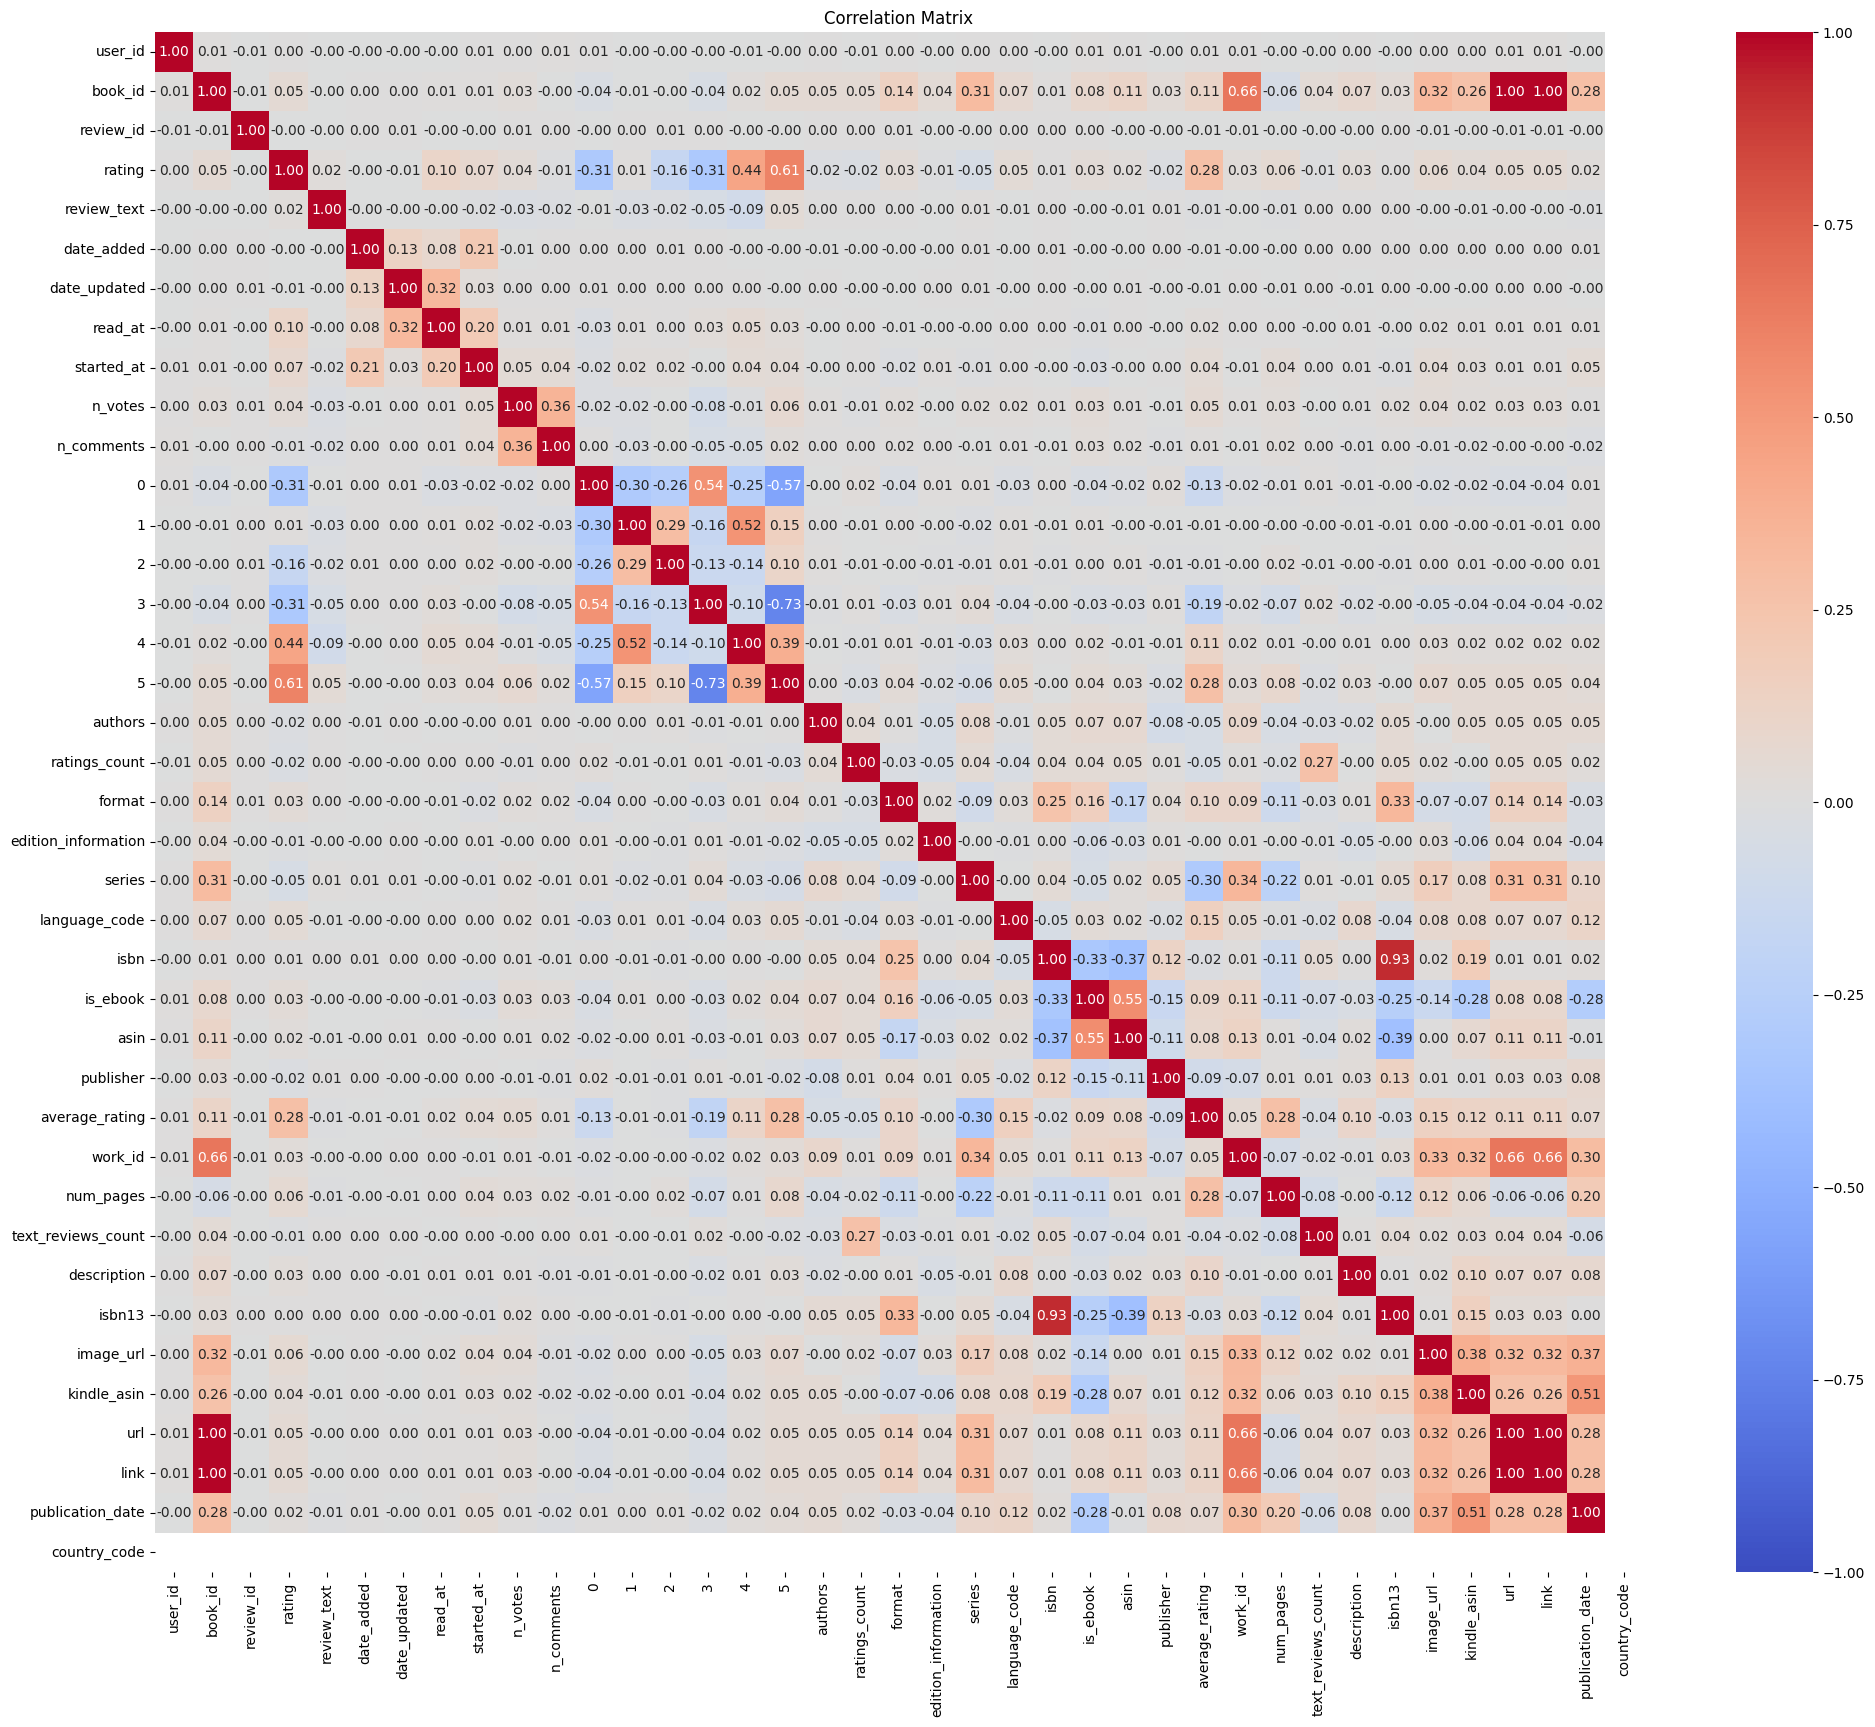

In [ ]:
# 2. Compute the correlation matrix
corr_matrix = df.corr()

# 3. Plot the correlation matrix using seaborn
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('drive/MyDrive/correlation_matrix_low.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.savefig('drive/MyDrive/correlation_matrix.png', dpi=900, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:
print(out.dtypes)
out_col = out.columns
df_col = df.columns
print(set(df_col))
print(set(out_col) - set(df_col))
print(len(df))
print(len(out))
columns_to_add = ['authors', 'ratings_count', 'format', 'edition_information', 'series', 'language_code', 'isbn', 'is_ebook', 'asin', 'publisher', 'average_rating', 'work_id', 'num_pages', 'text_reviews_count', 'description', 'isbn13', 'image_url', 'kindle_asin', 'url', 'link', 'publication_date', 'country_code']
merged_df = df.merge(out[columns_to_add + ['review_id']], on='review_id', how='left')

user_id                 object
review_id               object
rating                   int32
review_text             object
date_added              object
date_updated            object
read_at                 object
started_at              object
n_votes                  int32
n_comments               int32
isbn                    object
text_reviews_count     float64
series                  object
country_code            object
language_code           object
asin                    object
is_ebook                  bool
average_rating         float64
kindle_asin             object
description             object
format                  object
link                    object
authors                 object
publisher               object
num_pages              float64
isbn13                  object
edition_information     object
url                     object
image_url               object
ratings_count          float64
work_id                float64
publication_date        object
dtype: o

In [ ]:
print(len(merged_df))
print(merged_df.columns)
merged_df.to_csv('drive/MyDrive/merged_df_vector.csv')

90000
Index(['Unnamed: 0.1', 'Unnamed: 0', 'user_id', 'book_id', 'review_id',
       'rating', 'review_text', 'date_added', 'date_updated', 'read_at',
       'started_at', 'n_votes', 'n_comments', '0', '1', '2', '3', '4', '5',
       'authors', 'ratings_count', 'format', 'edition_information', 'series',
       'language_code', 'isbn', 'is_ebook', 'asin', 'publisher',
       'average_rating', 'work_id', 'num_pages', 'text_reviews_count',
       'description', 'isbn13', 'image_url', 'kindle_asin', 'url', 'link',
       'publication_date', 'country_code'],
      dtype='object')


In [ ]:
grouped = df.groupby(['book_id']).count().sort_values(by='review_id', ascending=False)
print(grouped.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'user_id', 'review_id', 'rating',
       'review_text', 'date_added', 'date_updated', 'read_at', 'started_at',
       'n_votes', 'n_comments', 'bert_pred'],
      dtype='object')


In [ ]:
# Load the dataset
data = dt.fread("drive/MyDrive/goodreads_train 2.csv",fill=True)

# Convert the datatable Frame to pandas DataFrame (for easier manipulation)
df = data.to_pandas()
df.columns = ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
print(df.dtypes)
print(len(df.index))
# Remove rows where rating is NAN
df = df.dropna(subset=['rating'])
df = df[pd.to_numeric(df['rating'], errors='coerce').notna()]

# Sort the dataframe based on the 'book_id' column
sorted_df = df.sort_values(by='book_id')

# Calculate the index of the middle row
middle_index = len(sorted_df) // 2

# Calculate the starting and ending indices for the middle 90,000 rows
start_index = middle_index - 45000
end_index = middle_index + 45000

print(start_index,end_index)

# Get the middle 90,000 rows
middle_rows = sorted_df.iloc[start_index:end_index]

middle_rows.to_csv('drive/MyDrive/middle_rows.csv')

user_id         object
book_id          int32
review_id       object
rating           int32
review_text     object
date_added      object
date_updated    object
read_at         object
started_at      object
n_votes          int32
n_comments       int32
dtype: object
900000
405000 495000


In [ ]:
grouped = middle_rows.groupby(['book_id']).count().sort_values(by='review_id', ascending=False)
print(grouped)
len(middle_rows)

          user_id  review_id  rating  review_text  date_added  date_updated  \
book_id                                                                       
15745753     1033       1033    1033         1033        1033          1033   
13335037     1017       1017    1017         1017        1017          1017   
13206760      994        994     994          994         994           994   
13206828      908        908     908          908         908           908   
15507958      856        856     856          856         856           856   
...           ...        ...     ...          ...         ...           ...   
13368216        2          2       2            2           2             2   
13157568        2          2       2            2           2             2   
15759494        2          2       2            2           2             2   
12997592        1          1       1            1           1             1   
15781690        1          1       1            1   

90000

# Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Assuming you have a dataframe called 'df'
df = pd.read_csv('drive/MyDrive/merged_df_vector.csv').fillna(0)
print(df.columns)
# df.drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])
df.drop(df.columns[[0, 1, 2]], axis=1, inplace=True)
# 1. Convert string columns to numeric values using Label Encoding
label_encoder = LabelEncoder()
df = df.apply(lambda col: label_encoder.fit_transform(col.astype(str)), axis=0, result_type='expand')

for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column has string data type
        df[column] = label_encoder.fit_transform(df[column])

# Assuming you have a dataframe called 'df' with features and a 'target' column for labels

# 1. Preprocess the data
# Separate features and target
X = df.drop(columns=['rating']).values
# Drop noncorrelated rows
# X = df[['read_at','started_at','text_reviews_count','language_code','asin','is_ebook','average_rating','kindle_asin','format','num_pages','image_url','ratings_count','work_id','publication_date']]
X = df[['read_at','started_at','average_rating','0','1','2','3','4','5']]
y = df['rating'].values

# 1. Convert string columns to numeric values using Label Encoding
# label_encoder = LabelEncoder()
# for column in X.columns:
#     if X[column].dtype == 'object':  # Check if the column has string data type
#         X[column] = label_encoder.fit_transform(X[column])
# X = X.fillna(0)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Create a custom dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 3. Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X.shape[1]
num_classes = 6
model = Net(input_size, num_classes)

# 4. Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # 5. Evaluate the model on validation set
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.4f}, Accuracy: {accuracy:.2f}')


<ipython-input-31-46a2f0ea600d>:11: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/MyDrive/merged_df_vector.csv').fillna(0)


Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'user_id', 'book_id',
       'review_id', 'rating', 'review_text', 'date_added', 'date_updated',
       'read_at', 'started_at', 'n_votes', 'n_comments', '0', '1', '2', '3',
       '4', '5', 'authors', 'ratings_count', 'format', 'edition_information',
       'series', 'language_code', 'isbn', 'is_ebook', 'asin', 'publisher',
       'average_rating', 'work_id', 'num_pages', 'text_reviews_count',
       'description', 'isbn13', 'image_url', 'kindle_asin', 'url', 'link',
       'publication_date', 'country_code'],
      dtype='object')
Epoch [1/100], Loss: 0.9428, Accuracy: 0.60
Epoch [2/100], Loss: 0.9418, Accuracy: 0.60
Epoch [3/100], Loss: 0.9463, Accuracy: 0.59
Epoch [4/100], Loss: 0.9280, Accuracy: 0.61
Epoch [5/100], Loss: 0.9240, Accuracy: 0.61
Epoch [6/100], Loss: 0.9352, Accuracy: 0.60
Epoch [7/100], Loss: 0.9236, Accuracy: 0.61
Epoch [8/100], Loss: 0.9248, Accuracy: 0.61
Epoch [9/100], Loss: 0.9289, Accuracy: 0.60
Epoch [10/10

In [ ]:
model.eval()
predicted_labels = []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        # 5. Pass the input tensors through the model
        output_tensor = model(X_batch)

        # 6. Interpret the model output
        if output_tensor.shape[-1] > 1:  # If there are multiple output values (e.g., class probabilities)
            _, batch_predicted_labels = torch.max(output_tensor, -1)  # Get the index of the maximum value (the predicted class label)
        else:
            batch_predicted_labels = (output_tensor > 0.5).int().squeeze()  # For binary classification with a single output value
        
        predicted_labels.extend(batch_predicted_labels.tolist())

    for X_batch, y_batch in val_loader:
        # 5. Pass the input tensors through the model
        output_tensor = model(X_batch)

        # 6. Interpret the model output
        if output_tensor.shape[-1] > 1:  # If there are multiple output values (e.g., class probabilities)
            _, batch_predicted_labels = torch.max(output_tensor, -1)  # Get the index of the maximum value (the predicted class label)
        else:
            batch_predicted_labels = (output_tensor > 0.5).int().squeeze()  # For binary classification with a single output value
        
        predicted_labels.extend(batch_predicted_labels.tolist())

print(f'Predicted labels: {predicted_labels}')

Predicted labels: [4, 5, 5, 3, 0, 3, 3, 3, 5, 4, 2, 4, 4, 3, 5, 4, 5, 5, 3, 2, 2, 4, 2, 4, 4, 4, 3, 5, 3, 4, 4, 2, 4, 4, 4, 5, 5, 4, 2, 3, 5, 4, 3, 4, 5, 4, 3, 4, 2, 4, 0, 2, 3, 4, 4, 5, 5, 1, 5, 5, 3, 4, 2, 1, 4, 5, 3, 4, 5, 4, 5, 0, 4, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 0, 3, 3, 4, 4, 5, 4, 1, 0, 3, 4, 4, 3, 5, 3, 4, 2, 2, 4, 4, 3, 5, 4, 3, 4, 3, 2, 3, 4, 5, 4, 4, 3, 4, 4, 3, 5, 5, 4, 4, 5, 2, 3, 5, 3, 2, 5, 3, 5, 4, 3, 1, 5, 3, 4, 4, 3, 3, 4, 5, 5, 4, 5, 2, 4, 5, 4, 4, 3, 4, 5, 3, 5, 4, 4, 5, 5, 5, 4, 4, 3, 3, 4, 4, 3, 4, 5, 5, 4, 4, 3, 5, 4, 3, 3, 4, 4, 5, 3, 5, 5, 5, 3, 3, 4, 5, 3, 3, 3, 5, 5, 3, 2, 5, 4, 4, 2, 4, 4, 4, 5, 5, 4, 3, 5, 4, 4, 3, 5, 3, 5, 4, 5, 5, 4, 3, 3, 4, 2, 3, 4, 5, 4, 3, 2, 4, 3, 4, 4, 1, 1, 4, 5, 5, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 3, 5, 4, 5, 4, 4, 5, 4, 4, 3, 5, 5, 4, 4, 4, 3, 3, 4, 3, 0, 4, 4, 5, 1, 5, 3, 3, 3, 4, 5, 4, 4, 4, 3, 5, 5, 3, 3, 1, 5, 4, 4, 4, 3, 2, 3, 4, 3, 4, 3, 5, 5, 3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 5, 5, 3, 4, 5, 4, 5, 3, 5, 3, 5, 5, 5, 4, 4, 4, 

In [ ]:
from sklearn.metrics import classification_report
print(y_pred)

# Generate and print the classification report
report = classification_report(np.append(y_train,y_val, axis=0), predicted_labels)
print(report)

tensor([[-3.2740e+00, -1.1228e+01, -5.4460e+00, -9.5182e-01,  2.0490e+00,
          8.6948e-01],
        [-4.9628e-01, -7.2608e+00, -8.8846e+00, -4.7350e-01, -1.3588e+00,
          4.0975e-01],
        [-4.2527e+00, -1.1425e+00, -1.8113e-01,  5.6593e-01,  7.9013e-01,
         -5.9043e-01],
        [-2.2606e+00, -5.7169e+00, -2.7675e+00,  6.0832e-01,  8.4560e-01,
         -1.8481e+00],
        [-3.8729e+00, -2.5706e+00, -5.6470e-01,  3.9410e-01,  2.7885e-01,
         -1.7198e-02],
        [-2.7804e+00, -1.0943e+01, -5.6111e+00, -1.6952e+00,  1.7610e+00,
          1.1208e+00],
        [-4.3413e+00, -2.8333e+00, -9.1652e-01,  4.7908e-01,  9.3964e-01,
          1.1926e-01],
        [-3.0592e+00, -1.2037e+01, -5.8106e+00, -2.4451e+00,  7.9192e-01,
          2.0760e+00],
        [-5.5583e+00, -2.4280e+01, -8.7037e+00, -2.8027e+00,  2.7101e+00,
          1.1621e+00],
        [-3.3902e+00, -1.2049e+01, -5.1818e+00, -4.0419e-01,  1.6576e+00,
          1.3499e-01],
        [-3.1739e+00, -1.5308e

In [ ]:
#!pip install tensorflow-gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# from tenserflow.keras import Model
# from tenserflow.keras.layers import Input, Dense
# from tenserflow.keras.optimizers import Adam
# from tenserflow.keras import regularizers


def create_model(input_shape, num_classes, learning_rate):
    # Create input layer
    inputs = keras.layers.Input(shape=input_shape)

    # Create hidden layer with relu activation and l2 regularization
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(inputs)

    # Create output layer with softmax activation because we have a multi-class classification problem
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile model with Adam optimizer and categorical crossentropy loss function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Train model
def train_model(model, x_train, y_train, x_test, y_test, batch_size, epochs):
    # Train model
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

    return history


# Evaluate model
def evaluate_model(model, x_test, y_test):
    # Evaluate model
    score = model.evaluate(x_test, y_test, verbose=0)

    return score


# Save model
def save_model(model, model_name):
    # Save model
    model.save(model_name)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd
df = pd.read_csv('drive/MyDrive/merged_df.csv')

# Assuming you have a dataframe called 'df' with features and a 'target' column for labels

# 1. Preprocess the data
# Separate features and target
X = df.drop(columns=['rating']).values
# Drop noncorrelated rows
X = df[['read_at','started_at','text_reviews_count','language_code','asin','is_ebook','average_rating','kindle_asin','format','num_pages','image_url','ratings_count','work_id','publication_date']]
y = df['rating'].values / 5.0
print(y)
num_of_columns = X.columns
# 1. Convert string columns to numeric values using Label Encoding
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':  # Check if the column has string data type
        X[column] = label_encoder.fit_transform(X[column])
X = X.fillna(0)
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-46-7ee916ef2ffa>:5: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/MyDrive/merged_df.csv')


[0.4 0.4 0.6 ... 0.8 0.6 0.6]


<ipython-input-46-7ee916ef2ffa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = label_encoder.fit_transform(X[column])
<ipython-input-46-7ee916ef2ffa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = label_encoder.fit_transform(X[column])
<ipython-input-46-7ee916ef2ffa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
model = create_model(len(num_of_columns),1,0.001)
#model, x_train, y_train, x_test, y_test, batch_size, epochs
train_model(model, X_train, y_train, X_val, y_val, 6, 10)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(6, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


12000/12000 [==============================] - 47s 4ms/step - loss: 110.6506 - accuracy: 0.3112 - val_loss: 305.9420 - val_accuracy: 0.3114
Epoch 2/10
12000/12000 [==============================] - 44s 4ms/step - loss: 656.1246 - accuracy: 0.3112 - val_loss: 1080.7021 - val_accuracy: 0.3114
Epoch 3/10
12000/12000 [==============================] - 31s 3ms/step - loss: 1652.9795 - accuracy: 0.3112 - val_loss: 2299.6025 - val_accuracy: 0.3114
Epoch 4/10
12000/12000 [==============================] - 31s 3ms/step - loss: 3091.3362 - accuracy: 0.3112 - val_loss: 3959.3823 - val_accuracy: 0.3114
Epoch 5/10
12000/12000 [==============================] - 31s 3ms/step - loss: 4972.0552 - accuracy: 0.3112 - val_loss: 6054.2764 - val_accuracy: 0.3114
Epoch 6/10
12000/12000 [==============================] - 33s 3ms/step - loss: 7285.7656 - accuracy: 0.3112 - val_loss: 8596.2441 - val_accuracy: 0.3114
Epoch 7/10
12000/12000 [==============================] - 33s 3ms/step - loss: 10033.9492 - accu

In [ ]:
from sklearn.metrics import classification_report
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred = np.append(y_pred_train,y_pred_val)
y_pred = np.around(y_pred * 5.0)
print(y_pred)

# Generate and print the classification report
report = classification_report(np.append(y_train,y_val)*5, y_pred)
print(report)

563/563 [==============================] - 1s 2ms/step
[5. 5. 5. ... 5. 5. 5.]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2982
         1.0       0.00      0.00      0.00      2698
         2.0       0.00      0.00      0.00      6801
         3.0       0.00      0.00      0.00     18004
         4.0       0.00      0.00      0.00     31503
         5.0       0.31      1.00      0.47     28012

    accuracy                           0.31     90000
   macro avg       0.05      0.17      0.08     90000
weighted avg       0.10      0.31      0.15     90000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
